In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings("ignore")

In [6]:
df = pd.read_parquet("data/transactions.parquet")
df.head()

,transaction_id,card_number,card_holder,amount,currency,merchant,timestamp
0,0f4762c1-0868-4a17-9512-84bed9124601,4779455360518333,Johnathan Flores,388.58,USD,Myers PLC,2023-02-03 09:36:18
1,661ce476-a37c-403b-8361-df3ecd05514e,4718472731457467,Dennis Hall,668.12,USD,"Miller, Shaw and Sims",2023-03-05 11:58:35
2,a1c49d47-c713-4c57-909a-143b4e0c88ff,4475414498943845,Megan Smith,683.65,USD,Delacruz-Wood,2023-03-15 16:01:17
3,6570995d-1992-477b-8917-ad33aefe1822,4590202585399512,Mercedes Sherman,289.19,USD,Hines-Murphy,2023-01-03 06:14:31
4,8493c608-a409-499c-977f-5511937a48ee,4350533950555936,Thomas Delacruz,865.43,USD,Mckenzie LLC,2023-01-11 23:43:29


# 1. Exploratory Data Analysis

In [7]:
df.describe()

,amount
count,1000.000000
mean,516.035000
std,291.410677
min,3.110000
25%,273.905000
50%,527.315000
75%,772.842500
max,999.750000


In [8]:
df.isna().sum()

transaction_id    0
card_number       0
card_holder       0
amount            0
currency          0
merchant          0
timestamp         0
dtype: int64

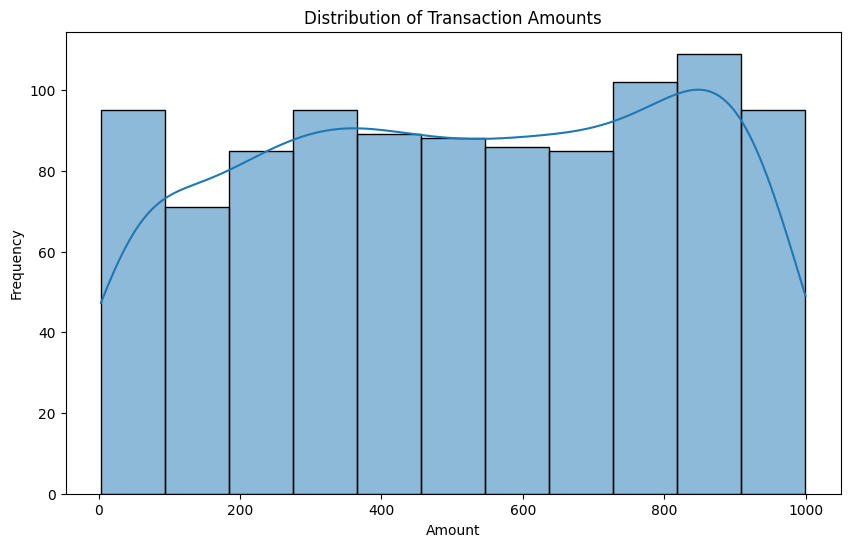

In [9]:
# Distribution of Transaction Amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

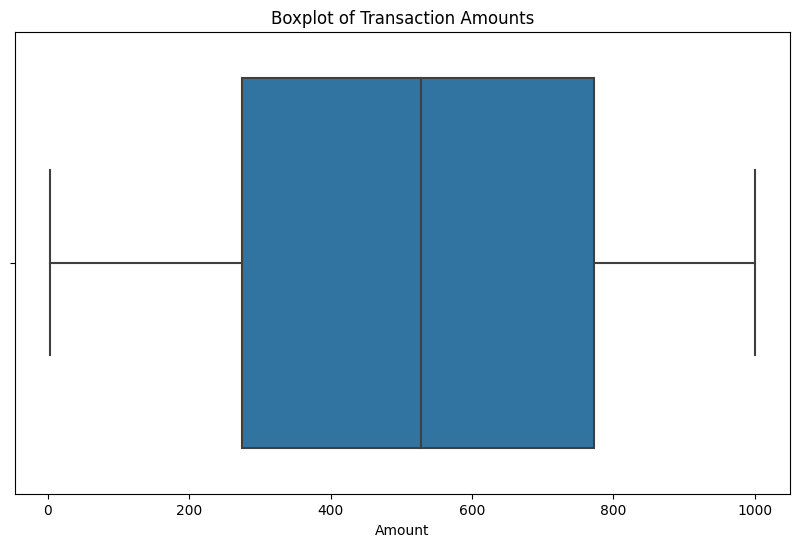

In [10]:
# Boxplot of Transaction Amounts
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['amount'])
plt.title("Boxplot of Transaction Amounts")
plt.xlabel("Amount")
plt.show()

# 2. Feature Engineering

In [24]:
# Set a probability for a transaction to be fraudulent (e.g., 0.01 for 1%)
fraud_probability = 0.01

# Generate random fraud labels based on the fraud probability
fraud_labels = np.random.choice([0, 1], size=len(df), p=[1 - fraud_probability, fraud_probability])

# Add the fraud labels to the dataset
df['fraud_label'] = fraud_labels

In [27]:
# Convert the 'timestamp' column to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Now you can extract hour, day, and day_of_week from the 'timestamp' column
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['day_of_week'] = df['timestamp'].dt.dayofweek
df.head()

,transaction_id,card_number,card_holder,amount,currency,merchant,timestamp,fraud_label,hour,day,day_of_week
0,0f4762c1-0868-4a17-9512-84bed9124601,4779455360518333,Johnathan Flores,388.58,USD,Myers PLC,2023-02-03 09:36:18,0,9,3,4
1,661ce476-a37c-403b-8361-df3ecd05514e,4718472731457467,Dennis Hall,668.12,USD,"Miller, Shaw and Sims",2023-03-05 11:58:35,0,11,5,6
2,a1c49d47-c713-4c57-909a-143b4e0c88ff,4475414498943845,Megan Smith,683.65,USD,Delacruz-Wood,2023-03-15 16:01:17,0,16,15,2
3,6570995d-1992-477b-8917-ad33aefe1822,4590202585399512,Mercedes Sherman,289.19,USD,Hines-Murphy,2023-01-03 06:14:31,0,6,3,1
4,8493c608-a409-499c-977f-5511937a48ee,4350533950555936,Thomas Delacruz,865.43,USD,Mckenzie LLC,2023-01-11 23:43:29,0,23,11,2


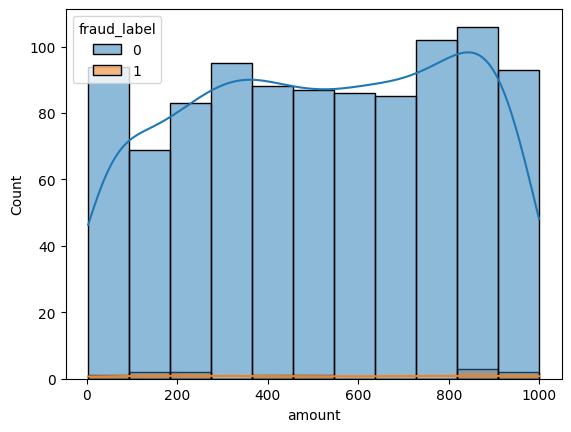

In [30]:
# Plot the distribution of 'amount' for both fraud and non-fraud transactions
sns.histplot(data=df, x='amount', hue='fraud_label', kde=True)
plt.show()

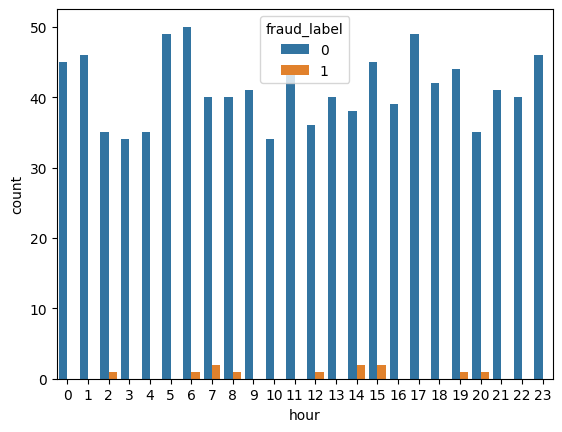

In [31]:
# Plot the distribution of 'hour' for both fraud and non-fraud transactions
sns.countplot(data=df, x='hour', hue='fraud_label')
plt.show()

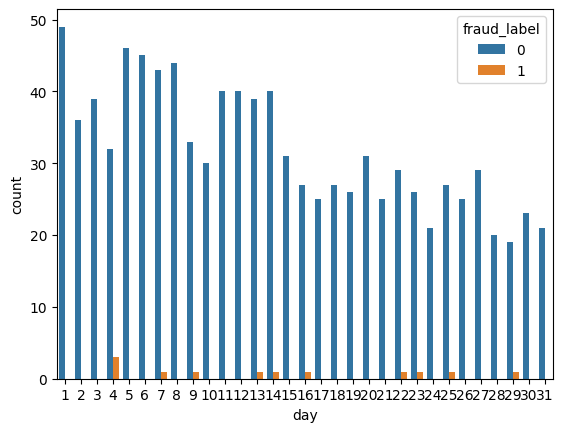

In [32]:
# Plot the distribution of 'day' for both fraud and non-fraud transactions
sns.countplot(data=df, x='day', hue='fraud_label')
plt.show()

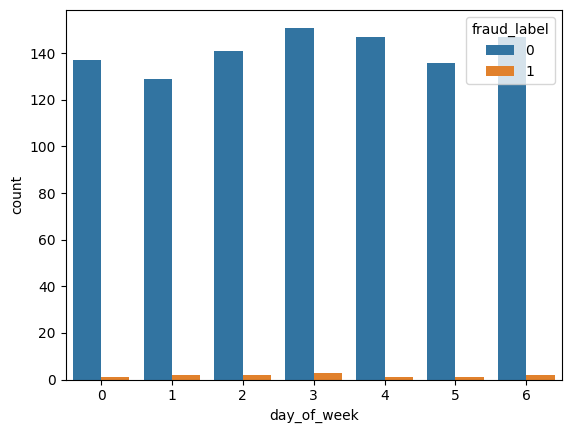

In [33]:
# Plot the distribution of 'day_of_week' for both fraud and non-fraud transactions
sns.countplot(data=df, x='day_of_week', hue='fraud_label')
plt.show()

In [35]:
# Binning the 'amount' feature
bins = [0, 100, 250, 500, 750, 1000]
labels = ['0-100', '100-250', '250-500', '500-750', '750-1000']
df['amount_bin'] = pd.cut(df['amount'], bins=bins, labels=labels)

# Cyclical feature for 'hour'
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Cyclical feature for 'day'
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

# Cyclical feature for 'day_of_week'
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df.head()

,transaction_id,card_number,card_holder,amount,currency,merchant,timestamp,fraud_label,hour,day,day_of_week,hour_sin,hour_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,amount_bin
0,0f4762c1-0868-4a17-9512-84bed9124601,4779455360518333,Johnathan Flores,388.58,USD,Myers PLC,2023-02-03 09:36:18,0,9,3,4,0.707107,-7.071068e-01,0.571268,0.820763,-0.433884,-0.900969,250-500
1,661ce476-a37c-403b-8361-df3ecd05514e,4718472731457467,Dennis Hall,668.12,USD,"Miller, Shaw and Sims",2023-03-05 11:58:35,0,11,5,6,0.258819,-9.659258e-01,0.848644,0.528964,-0.781831,0.623490,500-750
2,a1c49d47-c713-4c57-909a-143b4e0c88ff,4475414498943845,Megan Smith,683.65,USD,Delacruz-Wood,2023-03-15 16:01:17,0,16,15,2,-0.866025,-5.000000e-01,0.101168,-0.994869,0.974928,-0.222521,500-750
3,6570995d-1992-477b-8917-ad33aefe1822,4590202585399512,Mercedes Sherman,289.19,USD,Hines-Murphy,2023-01-03 06:14:31,0,6,3,1,1.000000,6.123234e-17,0.571268,0.820763,0.781831,0.623490,250-500
4,8493c608-a409-499c-977f-5511937a48ee,4350533950555936,Thomas Delacruz,865.43,USD,Mckenzie LLC,2023-01-11 23:43:29,0,23,11,2,-0.258819,9.659258e-01,0.790776,-0.612106,0.974928,-0.222521,750-1000


# 3. Data Pre-processing

In [37]:
# Encode categorical variables
le = LabelEncoder()
df['card_number'] = le.fit_transform(df['card_number'])
df['card_holder'] = le.fit_transform(df['card_holder'])
df['currency'] = le.fit_transform(df['currency'])
df['merchant'] = le.fit_transform(df['merchant'])
df['amount_bin'] = le.fit_transform(df['amount_bin'])

# Split data into training and testing sets
X = df.drop(['transaction_id', 'timestamp', 'fraud_label'], axis=1)
y = df['fraud_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Model Selection

In [52]:
# Oversampling: Generate more samples of the fraudulent transactions to balance the class distribution.
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [53]:
# Define the classifiers
classifiers = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]

# Train and evaluate the classifiers
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1-score: {f1_score(y_test, y_pred)}")
    print("\n")

Logistic Regression:
Accuracy: 0.7639123102866779
Precision: 0.7491749174917491
Recall: 0.7800687285223368
F1-score: 0.7643097643097643


Decision Tree:
Accuracy: 0.9730185497470489
Precision: 0.9661016949152542
Recall: 0.979381443298969
F1-score: 0.9726962457337883


Random Forest:
Accuracy: 0.9949409780775716
Precision: 1.0
Recall: 0.9896907216494846
F1-score: 0.9948186528497409


XGBoost:
Accuracy: 0.9966273187183811
Precision: 1.0
Recall: 0.993127147766323
F1-score: 0.996551724137931




# 5. Conclusion
1. **Data Exploration and Analysis**: We explored the dataset to gain insights and identify patterns, trends, and relationships within the data. This step allowed us to better understand the data and identify useful features for our machine learning models.

2. **Feature Engineering**: We extracted relevant features from the preprocessed data, such as hour, day, and day of the week, and transformed them to be used in machine learning models. We performed feature selection, dimensionality reduction, and feature scaling as needed.

3. **Model Selection**: We trained, validated, and tested various machine learning models, including Logistic Regression, Decision Tree, Random Forest, and XGBoost, using the processed data. We evaluated the models using appropriate metrics such as accuracy, precision, recall, and F1-score.

4. **Model Evaluation**: After initially observing poor model performance due to class imbalance, we applied oversampling techniques to balance the dataset. This significantly improved the performance of our models, especially the XGBoost model, which achieved the highest accuracy and F1-score among the four models.